#1. Energy Load Data Pull (hourly) for single day.


## Install and Verify CAISO GridStatus Package


The following commands will install the `gridstatus` package, upgrade it if already installed, and print its version to verify the installation. `gridstatus` provides access to real-time grid data from the California Independent System Operator (CAISO), allowing users to retrieve information about grid conditions, such as energy demand, supply, and other operational metrics relevant to CAISO's grid.


In [ ]:
!python -m pip install gridstatus
!python -m pip install --upgrade gridstatus
import gridstatus
print(gridstatus.__version__)

In [ ]:
!pip install prophet


## Setting up libraries

The following code imports several libraries and modules to facilitate data analysis, visualization, and interaction with the grid data:

- **`numpy`** and **`pandas`**: Used for numerical computations and data manipulation.
- **`matplotlib.pyplot`** and **`seaborn`**: Utilized for creating various types of data visualizations (e.g., plots, graphs).
- **`scipy.stats`**: Provides statistical functions to analyze data.
- **`IPython.core.interactiveshell`**: Modifies the interactive shell behavior to display all outputs in Jupyter/Colab cells.
- **`datetime` and `timedelta`**: Handle date and time manipulations, such as working with timestamps and date differences.
- **`tqdm_notebook`**: Displays a progress bar for iterative operations in Jupyter/Colab.
- **`gridstatus`**: Allows access to real-time grid data from the California Independent System Operator (CAISO), enabling retrieval of grid conditions such as energy demand, supply, and other operational metrics.

These libraries and modules together help with data analysis, visualization, real-time grid monitoring, and efficient interaction within a Jupyter/Colab environment.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import os
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

import gridstatus
from datetime import datetime, timedelta

from prophet import Prophet



# CAISO Data Analysis for March 15, 2025

This notebook fetches and processes data from CAISO, including electricity load, market prices, and renewable generation for March 15, 2025.

1. **Install Required Libraries**:  
   The required libraries (`pandas` and `gridstatus`) are installed.

2. **Import Libraries**:  
   `pandas` is imported for data manipulation, `datetime` for handling date and time, and `CAISO` and `Markets` from `gridstatus` for accessing CAISO data.

3. **Setup CAISO Object and Date Range**:  
   A `CAISO` object is created, and the date range is set for March 15, 2025 (from midnight to 11:59 PM).

4. **Fetch Data**:  
   The following datasets are fetched from CAISO:
   - `load_df`: Electricity demand (load) for the specified date.
   - `day_ahead_df`: Day-Ahead Market prices (hourly) for the date.
   - `real_time_df`: Real-Time Market prices (5-minute intervals) for the date.
   - `renewable_df`: Solar and wind generation forecasts for the date.

5. **Convert Timestamps**:  
   The timestamp columns in each dataframe are converted to `datetime` format for consistency when merging.

6. **Merge Dataframes**:  
   - The dataframes are merged using `merge_asof` to align on the nearest timestamp.
   - The `load_df` is merged with `day_ahead_df` for Day-Ahead prices.
   - The merged dataframe is then combined with `real_time_df` for Real-Time prices.
   - Finally, the renewable generation data (`renewable_df`) is merged.

7. **Handle Missing Data**:  
   Any missing values in the merged dataframe are forward-filled to ensure no gaps in the data.

8. **Select Relevant Columns**:  
   The final dataframe includes the following columns: `Interval Start`, `Load`, `LMP_DA` (Day-Ahead Market Price), `LMP_RT` (Real-Time Market Price), `Solar MW`, and `Wind MW`.

9. **Output**:  
   The first few rows of the final dataframe are displayed to inspect the combined data.


In [58]:
import pandas as pd
from datetime import datetime, timedelta
from gridstatus import CAISO, Markets

# Create CAISO object
caiso = CAISO()

# Set the specific date: March 15, 2025
start_date = datetime(2025, 3, 15, 0, 0, 0)  # March 15, 2025, 00:00:00-07:00
end_date = datetime(2025, 3, 15, 23, 59, 59)  # March 15, 2025, 23:59:59-07:00

# Fetch load data (demand)
load_data = caiso.get_load(start=start_date, end=end_date)
load_df = pd.DataFrame(load_data)

# Fetch Day-Ahead market prices (Hourly)
day_ahead_prices = caiso.get_lmp(start=start_date, end=end_date, market=Markets.DAY_AHEAD_HOURLY)
day_ahead_df = pd.DataFrame(day_ahead_prices)

# Fetch Real-Time market prices (5-min)
real_time_prices = caiso.get_lmp(start=start_date, end=end_date, market=Markets.REAL_TIME_5_MIN)
real_time_df = pd.DataFrame(real_time_prices)

# Fetch renewable generation (solar and wind forecast)
today_date = end_date.strftime('%Y-%m-%d')
renewable_generation = caiso.get_solar_and_wind_forecast_dam(date=today_date)
renewable_df = pd.DataFrame(renewable_generation)

# Debugging: print column names and a few rows of each dataframe
print("Load Data Columns:", load_df.columns)
print(load_df.head())

print("\nDay-Ahead Prices Columns:", day_ahead_df.columns)
print(day_ahead_df.head())

print("\nReal-Time Prices Columns:", real_time_df.columns)
print(real_time_df.head())

print("\nRenewable Generation Columns:", renewable_df.columns)
print(renewable_df.head())

# Ensure all dataframes have the same timestamp format to allow merging
load_df['Interval Start'] = pd.to_datetime(load_df['Interval Start'])
day_ahead_df['Time'] = pd.to_datetime(day_ahead_df['Time'])
real_time_df['Time'] = pd.to_datetime(real_time_df['Time'])
renewable_df['Interval Start'] = pd.to_datetime(renewable_df['Interval Start'])

# Sort all dataframes
load_df = load_df.sort_values('Interval Start')
day_ahead_df = day_ahead_df.sort_values('Time')
real_time_df = real_time_df.sort_values('Time')
renewable_df = renewable_df.sort_values('Interval Start')

# Merge load_df with day_ahead_df using merge_asof for alignment (nearest time match)
combined_df = pd.merge_asof(load_df, day_ahead_df[['Time', 'LMP']],
                            left_on='Interval Start', right_on='Time', direction='nearest')

# Merge with real_time_df (5-minute data) using merge_asof
combined_df = pd.merge_asof(combined_df, real_time_df[['Time', 'LMP']],
                            left_on='Interval Start', right_on='Time', direction='nearest', suffixes=('_DA', '_RT'))

# Merge renewable_df (solar and wind generation) using merge_asof
combined_df = pd.merge_asof(combined_df, renewable_df[['Interval Start', 'Solar MW', 'Wind MW']],
                            left_on='Interval Start', right_on='Interval Start', direction='nearest')

# Handle missing values by forward filling
combined_df = combined_df.ffill()

# Select the relevant columns for the final output
combined_df = combined_df[['Interval Start', 'Load', 'LMP_DA', 'LMP_RT', 'Solar MW', 'Wind MW']]

# Debugging: show the final dataframe
print("\nCombined DataFrame:")
print(combined_df.head())


2025-03-22 23:57:55 - INFO - Fetching URL: https://www.caiso.com/outlook/history/20250315/demand.csv?_=1742687875
INFO:gridstatus:Fetching URL: https://www.caiso.com/outlook/history/20250315/demand.csv?_=1742687875
2025-03-22 23:57:56 - DEBUG - Dataset config: {'query': {'path': 'SingleZip', 'resultformat': 6, 'queryname': 'PRC_LMP', 'version': 12}, 'params': {'market_run_id': 'DAM', 'node': None, 'grp_type': [None, 'ALL', 'ALL_APNODES']}}
DEBUG:gridstatus:Dataset config: {'query': {'path': 'SingleZip', 'resultformat': 6, 'queryname': 'PRC_LMP', 'version': 12}, 'params': {'market_run_id': 'DAM', 'node': None, 'grp_type': [None, 'ALL', 'ALL_APNODES']}}
2025-03-22 23:57:56 - INFO - Fetching URL: http://oasis.caiso.com/oasisapi/SingleZip?resultformat=6&queryname=PRC_LMP&version=12&market_run_id=DAM&node=TH_NP15_GEN-APND,TH_SP15_GEN-APND,TH_ZP26_GEN-APND&startdatetime=20250315T07:00-0000&enddatetime=20250316T06:59-0000
INFO:gridstatus:Fetching URL: http://oasis.caiso.com/oasisapi/SingleZip

Load Data Columns: Index(['Time', 'Interval Start', 'Interval End', 'Load'], dtype='object')
                       Time            Interval Start  \
0 2025-03-15 00:00:00-07:00 2025-03-15 00:00:00-07:00   
1 2025-03-15 00:05:00-07:00 2025-03-15 00:05:00-07:00   
2 2025-03-15 00:10:00-07:00 2025-03-15 00:10:00-07:00   
3 2025-03-15 00:15:00-07:00 2025-03-15 00:15:00-07:00   
4 2025-03-15 00:20:00-07:00 2025-03-15 00:20:00-07:00   

               Interval End   Load  
0 2025-03-15 00:05:00-07:00  22496  
1 2025-03-15 00:10:00-07:00  22619  
2 2025-03-15 00:15:00-07:00  22882  
3 2025-03-15 00:20:00-07:00  22863  
4 2025-03-15 00:25:00-07:00  22824  

Day-Ahead Prices Columns: Index(['Time', 'Interval Start', 'Interval End', 'Market', 'Location',
       'Location Type', 'LMP', 'Energy', 'Congestion', 'Loss'],
      dtype='object')
                       Time            Interval Start  \
0 2025-03-15 00:00:00-07:00 2025-03-15 00:00:00-07:00   
1 2025-03-15 00:00:00-07:00 2025-03-15 00:00

In [37]:
# Print the combined table
combined_df.head(300)

,Interval Start,Load,LMP_DA,LMP_RT,Solar MW,Wind MW
0,2025-03-15 00:00:00-07:00,22496,44.53705,49.14920,0.0,67.53
1,2025-03-15 00:05:00-07:00,22619,44.53705,51.11313,0.0,67.53
2,2025-03-15 00:10:00-07:00,22882,44.53705,53.03753,0.0,67.53
3,2025-03-15 00:15:00-07:00,22863,44.53705,49.70261,0.0,67.53
4,2025-03-15 00:20:00-07:00,22824,44.53705,48.26138,0.0,67.53
...,...,...,...,...,...,...
283,2025-03-15 23:35:00-07:00,21612,46.07396,45.85097,0.0,54.30
284,2025-03-15 23:40:00-07:00,21468,46.07396,45.85097,0.0,54.30
285,2025-03-15 23:45:00-07:00,21379,46.07396,45.36353,0.0,54.30
286,2025-03-15 23:50:00-07:00,21293,46.07396,44.76069,0.0,54.30


# Data Analysis and Visualization

This section of the notebook performs the following steps on the `combined_df` dataframe:

1. **Basic Dataframe Information**:  
   - `combined_df.info()`: Displays information about the dataframe such as the number of entries, column names, non-null values, and data types.
   - `combined_df.describe()`: Provides summary statistics (mean, standard deviation, min, max, etc.) for numerical columns.

2. **Extracting Date Range**:  
   - `min_date = combined_df['Interval Start'].min()`: Finds the earliest timestamp in the 'Interval Start' column.
   - `max_date = combined_df['Interval Start'].max()`: Finds the latest timestamp in the 'Interval Start' column.
   - The minimum and maximum dates are then printed to provide insight into the time range of the data.

3. **Timezone Removal**:  
   - `combined_df['Interval Start'] = combined_df['Interval Start'].dt.tz_localize(None)`: Removes timezone information from the 'Interval Start' column to ensure uniformity in time handling.

4. **Set 'Interval Start' as Index**:  
   - `combined_df.set_index('Interval Start', inplace=True)`: Sets 'Interval Start' as the index of the dataframe, which allows for easier time-based operations.

5. **Resampling to Hourly Frequency**:  
   - `df_hourly = combined_df.resample('H').mean()`: Resamples the data to hourly intervals, calculating the mean of all columns within each hour.

6. **Reset Index**:  
   - `df_hourly.reset_index(inplace=True)`: Resets the index to make 'Interval Start' a column again, making it easier to work with.

7. **Display First Few Rows of Aggregated Data**:  
   - `df_hourly.head(50)`: Displays the first 50 rows of the newly aggregated hourly dataframe.

8. **Plotting Hourly Aggregated Load Data**:  
   - A plot is generated showing the hourly aggregated load data over time:
     - The x-axis represents time (`Interval Start`).
     - The y-axis represents the load values.
     - The plot is customized with a title, axis labels, and rotated x-axis labels for better readability.
     - The plot is displayed with `plt.show()`.

This section provides both statistical insights into the data and a time series plot to visually explore how load changes over time.


In [59]:
combined_df.info()
combined_df.describe()

min_date = combined_df['Interval Start'].min()
max_date = combined_df['Interval Start'].max()

print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype                     
---  ------          --------------  -----                     
 0   Interval Start  288 non-null    datetime64[ns, US/Pacific]
 1   Load            288 non-null    int64                     
 2   LMP_DA          288 non-null    float64                   
 3   LMP_RT          288 non-null    float64                   
 4   Solar MW        288 non-null    float64                   
 5   Wind MW         288 non-null    float64                   
dtypes: datetime64[ns, US/Pacific](1), float64(4), int64(1)
memory usage: 13.6 KB


,Load,LMP_DA,LMP_RT,Solar MW,Wind MW
count,288.000000,288.000000,288.000000,288.000000,288.000000
mean,19838.861111,18.693750,15.921922,2810.583229,919.591007
std,3088.578625,33.372005,42.636320,4907.379688,1152.899130
min,13913.000000,-43.110440,-74.507960,0.000000,48.050000
25%,17047.500000,-9.671600,-27.285870,0.000000,60.900000
50%,20860.000000,38.519880,42.384355,131.775000,171.790000
75%,22277.500000,46.073960,47.395215,2576.200000,2324.700000
max,23590.000000,51.468190,69.812570,17506.400000,3368.630000


Minimum date: 2025-03-15 00:00:00-07:00
Maximum date: 2025-03-15 23:55:00-07:00


In [60]:
combined_df['Interval Start'] = combined_df['Interval Start'].dt.tz_localize(None)

In [61]:
combined_df.info()
combined_df.describe()

min_date = combined_df['Interval Start'].min()
max_date = combined_df['Interval Start'].max()

print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Interval Start  288 non-null    datetime64[ns]
 1   Load            288 non-null    int64         
 2   LMP_DA          288 non-null    float64       
 3   LMP_RT          288 non-null    float64       
 4   Solar MW        288 non-null    float64       
 5   Wind MW         288 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 13.6 KB


,Interval Start,Load,LMP_DA,LMP_RT,Solar MW,Wind MW
count,288,288.000000,288.000000,288.000000,288.000000,288.000000
mean,2025-03-15 11:57:30,19838.861111,18.693750,15.921922,2810.583229,919.591007
min,2025-03-15 00:00:00,13913.000000,-43.110440,-74.507960,0.000000,48.050000
25%,2025-03-15 05:58:45,17047.500000,-9.671600,-27.285870,0.000000,60.900000
50%,2025-03-15 11:57:30,20860.000000,38.519880,42.384355,131.775000,171.790000
75%,2025-03-15 17:56:15,22277.500000,46.073960,47.395215,2576.200000,2324.700000
max,2025-03-15 23:55:00,23590.000000,51.468190,69.812570,17506.400000,3368.630000
std,NaN,3088.578625,33.372005,42.636320,4907.379688,1152.899130


Minimum date: 2025-03-15 00:00:00
Maximum date: 2025-03-15 23:55:00


In [62]:
# Set 'Interval Start' as the index for resampling
combined_df.set_index('Interval Start', inplace=True)

# Resample the data to hourly frequency and calculate the mean of all columns
df_hourly = combined_df.resample('H').mean()

# Reset the index to make 'Interval Start' a column again
df_hourly.reset_index(inplace=True)

# Display the first few rows of the aggregated dataframe
df_hourly.head(50)


<ipython-input-62-2ad365b8d102>:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = combined_df.resample('H').mean()


,Interval Start,Load,LMP_DA,LMP_RT,Solar MW,Wind MW
0,2025-03-15 00:00:00,22553.750000,43.683483,46.171775,0.000000,1442.988333
1,2025-03-15 01:00:00,21863.833333,40.863061,45.537341,0.000000,70.604167
2,2025-03-15 02:00:00,20976.250000,38.199530,49.302947,0.000000,1598.727500
3,2025-03-15 03:00:00,20541.500000,38.000329,45.696711,0.000000,71.208333
4,2025-03-15 04:00:00,20478.500000,40.582507,46.319772,0.000000,1575.530833
5,2025-03-15 05:00:00,20978.166667,47.268966,49.709373,5.762500,1364.883333
6,2025-03-15 06:00:00,21957.000000,48.112075,48.107647,104.050000,67.143333
7,2025-03-15 07:00:00,22659.166667,24.382257,36.753437,1818.094167,1483.673333
8,2025-03-15 08:00:00,21891.250000,21.144567,5.494218,6689.065833,1546.653333
9,2025-03-15 09:00:00,20093.333333,-11.557502,-16.086454,11512.480000,2186.655833


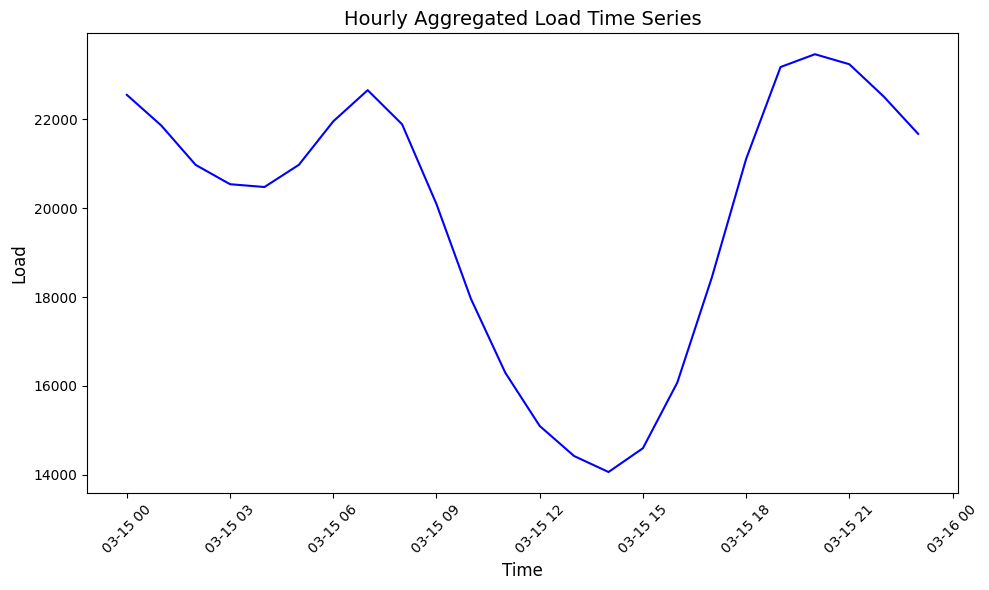

In [63]:
import matplotlib.pyplot as plt

# Plot the hourly aggregated Load data
plt.figure(figsize=(10, 6))

# Plot Load
plt.plot(df_hourly['Interval Start'], df_hourly['Load'], label='Load', color='blue')

# Add title and labels
plt.title("Hourly Aggregated Load Time Series", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Load", fontsize=12)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show();


# Visualization of Key Variables

This section creates a series of plots to visualize the hourly data for different variables:

1. **Create Subplots**:  
   - `fig, axs = plt.subplots(5, 1, figsize=(20, 10), sharex=True)`: A figure with 5 subplots (rows) and 1 column is created, all sharing the same x-axis. The figure size is set to 20x10 inches.

2. **Plot Hourly Wind Generation**:  
   - The first subplot (`axs[0]`) displays the hourly wind generation data (`Wind MW`) with a blue line.
   - The title and y-axis label are set to 'Hourly Wind Generation' and 'Wind MW', respectively.

3. **Plot Hourly Day-Ahead LMP (Locational Marginal Price)**:  
   - The second subplot (`axs[1]`) shows the hourly Day-Ahead LMP (`LMP_DA`) with a green line.
   - The title and y-axis label are set to 'Hourly Day-Ahead LMP' and 'LMP (DA)', respectively.

4. **Plot Hourly Real-Time LMP**:  
   - The third subplot (`axs[2]`) plots the hourly Real-Time LMP (`LMP_RT`) with a red line.
   - The title and y-axis label are set to 'Hourly Real-Time LMP' and 'LMP (RT)', respectively.

5. **Plot Hourly Solar Generation**:  
   - The fourth subplot (`axs[3]`) shows the hourly solar generation data (`Solar MW`) with an orange line.
   - The title and y-axis label are set to 'Hourly Solar Generation' and 'Solar MW', respectively.

6. **Plot Hourly Aggregated Load**:  
   - The fifth subplot (`axs[4]`) displays the hourly aggregated load (`Load`) with a purple line.
   - The title and y-axis label are set to 'Hourly Aggregated Load' and 'Load', respectively.

7. **Format x-Axis**:  
   - For all subplots, the x-axis is formatted to show hourly ticks (`Interval Start`) with the time displayed in 'Hour:Minute' format.
   - `ax.set_xticks(df_hourly['Interval Start'][::1])`: Sets a tick for every hour.
   - `ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))`: Formats the x-axis labels to display hours and minutes.

8. **Rotate x-axis Labels**:  
   - The x-axis labels are rotated by 45 degrees for better readability.

9. **Add x-Axis Label**:  
   - A shared x-axis label "Time (Hourly)" is added to the bottom.

10. **Adjust Layout**:  
    - `plt.tight_layout()`: Adjusts the layout to prevent overlap and ensures proper spacing between subplots.

11. **Display the Plot**:  
    - `plt.show()`: Displays the complete set of plots in the figure.

This section provides a visual comparison of wind generation, LMP values, solar generation, and load over time in a clear and organized layout.


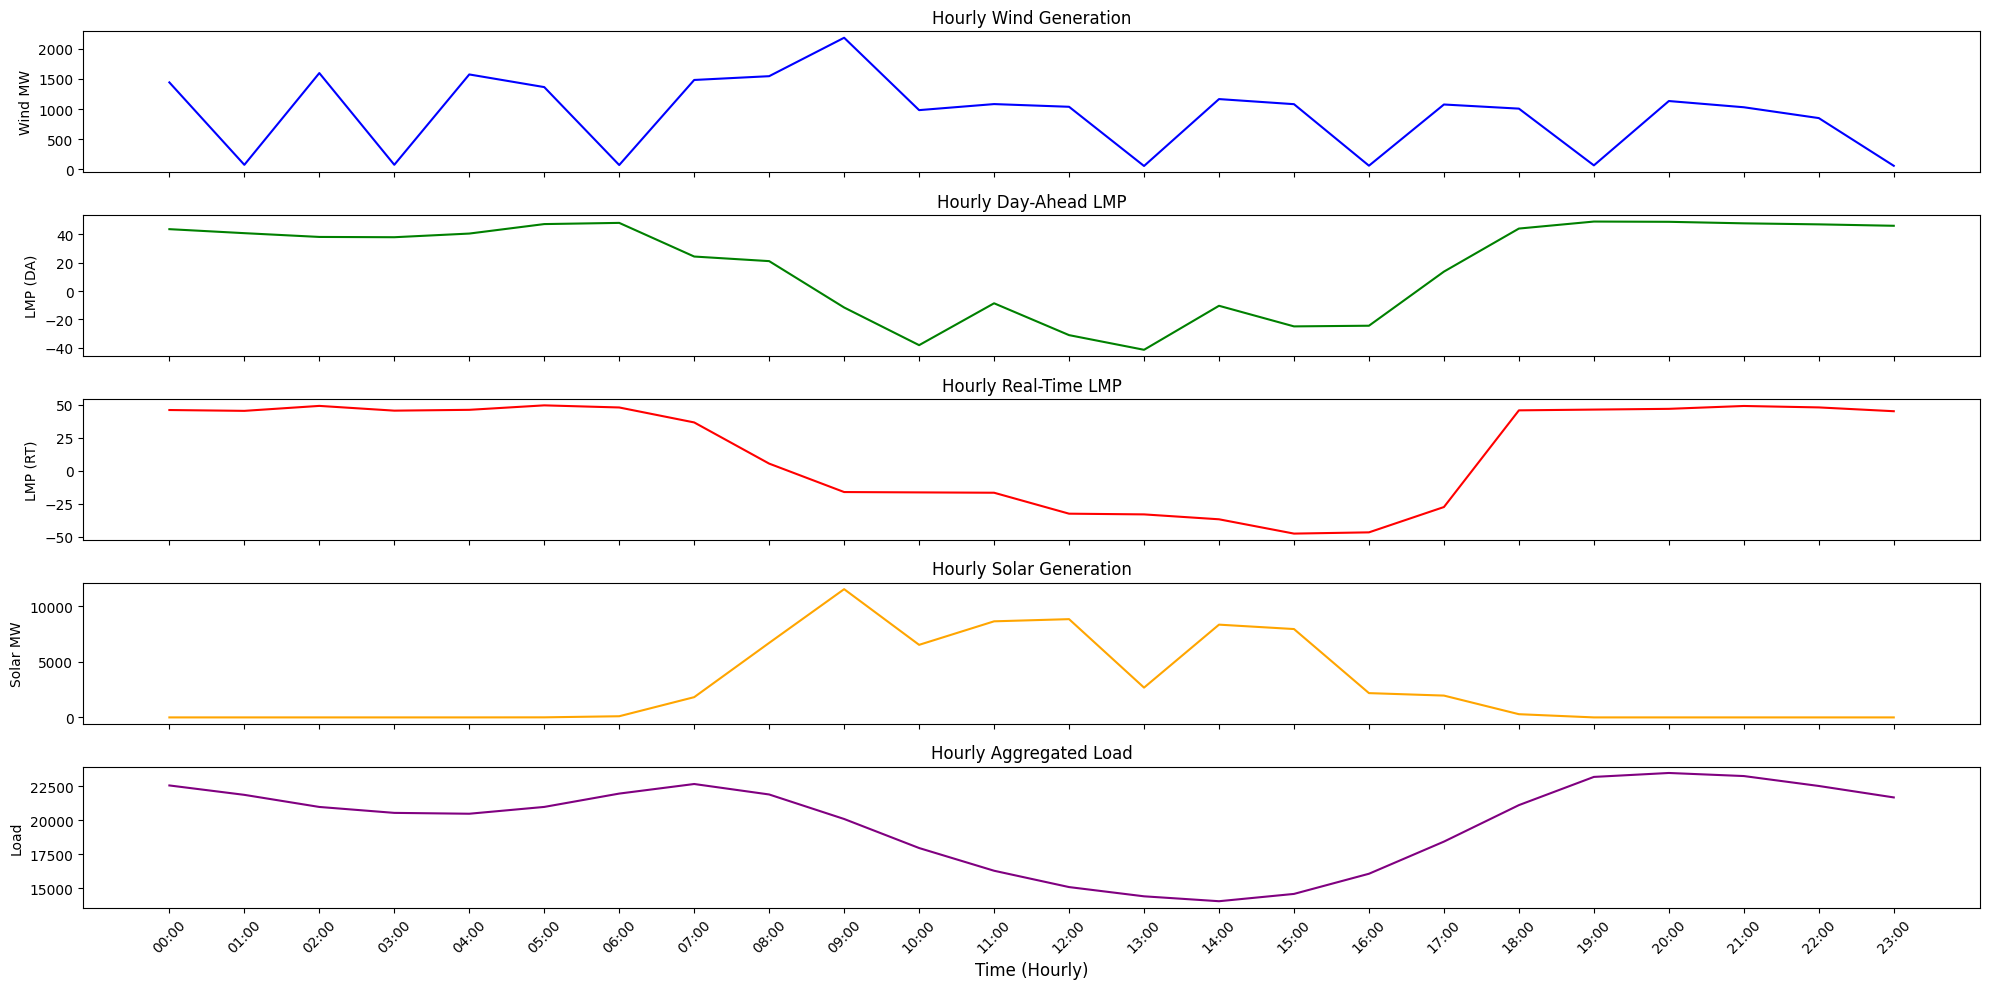

In [64]:
import matplotlib.pyplot as plt

# Create a figure with multiple subplots (5 rows, 1 column)
fig, axs = plt.subplots(5, 1, figsize=(20, 10), sharex=True)

# Plot each variable in its respective subplot
axs[0].plot(df_hourly['Interval Start'], df_hourly['Wind MW'], color='blue')
axs[0].set_title('Hourly Wind Generation', fontsize=12)
axs[0].set_ylabel('Wind MW', fontsize=10)

axs[1].plot(df_hourly['Interval Start'], df_hourly['LMP_DA'], color='green')
axs[1].set_title('Hourly Day-Ahead LMP', fontsize=12)
axs[1].set_ylabel('LMP (DA)', fontsize=10)

axs[2].plot(df_hourly['Interval Start'], df_hourly['LMP_RT'], color='red')
axs[2].set_title('Hourly Real-Time LMP', fontsize=12)
axs[2].set_ylabel('LMP (RT)', fontsize=10)

axs[3].plot(df_hourly['Interval Start'], df_hourly['Solar MW'], color='orange')
axs[3].set_title('Hourly Solar Generation', fontsize=12)
axs[3].set_ylabel('Solar MW', fontsize=10)

axs[4].plot(df_hourly['Interval Start'], df_hourly['Load'], color='purple')
axs[4].set_title('Hourly Aggregated Load', fontsize=12)
axs[4].set_ylabel('Load', fontsize=10)

# Set hourly ticks for the x-axis (Interval Start)
for ax in axs:
    ax.set_xticks(df_hourly['Interval Start'][::1])  # Use a tick for every hour
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))  # Format the ticks to show hours and minutes

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Add x-axis label for the shared axis
plt.xlabel("Time (Hourly)", fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()


# Show the plot
plt.show();
